### Introduction 
<br/>

[Competition](https://www.crowdanalytix.com/contests/propensity-to-fund-mortgages)  

<br/>

#### Objective
The objective of this contest is as follows:  
- Develop a model to predict, given mortgage application information, whether the mortgage will be funded or not.
- Identify significant elements in customer mortgage application data that will ultimately lead to their mortgage being funded/declined.

**Outcome**: The successful solvers will have created the most accurate and robust predictive model to determine the propensity to fund based on the data provided by the Seeker.

<br/>

#### Data
**There are 20 fields in the dataset, which represent a past customer’s mortgage application data.**   
The fields and descriptions are listed in Data tab in CAX_MortgageModeling_DataDictionary.docx.  
The dataset is divided into train and test set. The test set is further divided into public test and private test for public & private leaderboard scoring.
The following data files can be downloaded from data tab:
- CAX_MortgageModeling_Train.csv
- CAX_MortgageModeling_Test.csv
- CAX_MortgageModeling_SubmissionFormat.csv
- CAX_MortgageModeling_DataDictionary.docx  
  
The variable to be predicted is “Result”.

<br/>

#### Evaluation Metric: 
- <span style='color:red'>macro F1 score</span> (Primary)
- Precision-Recall
- Accuracy



### Import Libraries

In [11]:
import os, sys, time, gc, warnings, re 
import datetime as dt
warnings.filterwarnings("ignore")

import itertools as it
import operator as op

import numpy as np
import scipy.stats as stats
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML, Markdown

sys.path.append(os.environ["PY_UTILITIES_LIBRARY"]) # PY_UTILITIES_LIBRARY points to our custom library

%matplotlib inline

In [12]:
%reload_ext watermark
%watermark -iv -d -t -v -w -m

pandas    0.24.2
re        2.2.1
sklearn   0.20.3
seaborn   0.9.0
json      2.0.9
scipy     1.2.1
numpy     1.16.2
matplotlib3.0.3
2019-05-12 06:00:35 

CPython 3.6.8
IPython 7.5.0

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores  : 12
interpreter: 64bit
watermark 1.8.0


### Configure Notebook

In [13]:
np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)
pd.set_option("display.max_colwidth", -1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('io.hdf.default_format','fixed') # store binary data in HDF5 'table' format or 'fixed' format
sns.set(context='paper', style="darkgrid", rc={'axes.labelcolor': 'black', 'xtick.color': 'black', 'ytick.color': 'black', 'figure.facecolor':'white'}, 
        font_scale=1.3)
HTML("<style>table {font-size:14px} </style>")

def printmd(string, color=None):
    """colors in hex"""
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

In [14]:
%reload_ext autoreload
%autoreload 2

rs_seed = np.random.RandomState(seed=43)

In [15]:
# imports
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

In [16]:
# imports
from ml_toolbelt.utils.stat_utils import (describe_categorical, describe_numeric, check_level_diff_nominal, 
                                          check_train_test_diff_quantitative, check_train_test_missing, show_feature_diff_train_test 
                                          )
from ml_toolbelt.mlutils.ml_utils import visualize_coefficients
from ml_toolbelt.mlutils.metrics import mutual_information, info_gain_ratio

### Define Notebook Parameters

In [17]:
# see papermill package
train_file = "./CAX_MortgageModeling_Train.csv"
test_file = "./CAX_MortgageModeling_Test.csv"

submission_fields = ["Unique_ID", "Result_Predicted"]
target = "RESULT"
object_id = "Unique_ID"

In [18]:
train_df = pd.read_csv(train_file)
print(train_df.shape)
test_df = pd.read_csv(test_file)
print(test_df.shape)

train_df.info()

(45642, 22)
(15214, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45642 entries, 0 to 45641
Data columns (total 22 columns):
Unique_ID            45642 non-null object
MORTGAGE NUMBER      45642 non-null int64
PROPERTY VALUE       45642 non-null int64
MORTGAGE PAYMENT     45642 non-null int64
GDS                  45642 non-null float64
LTV                  45642 non-null float64
TDS                  45642 non-null float64
AMORTIZATION         45642 non-null int64
MORTGAGE AMOUNT      45642 non-null float64
RATE                 45642 non-null float64
MORTGAGE PURPOSE     45642 non-null object
PAYMENT FREQUENCY    45642 non-null object
PROPERTY TYPE        45642 non-null object
TERM                 45642 non-null int64
FSA                  45642 non-null object
AGE RANGE            45642 non-null object
GENDER               45642 non-null object
INCOME               45642 non-null int64
INCOME TYPE          45642 non-null int64
NAICS CODE           45642 non-null object
CREDIT SC

In [19]:
test_df.drop(["RESULT"], axis=1, inplace=True)
test_df.shape

(15214, 21)

In [20]:
train_df.head()

,Unique_ID,MORTGAGE NUMBER,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,MORTGAGE PURPOSE,PAYMENT FREQUENCY,PROPERTY TYPE,TERM,FSA,AGE RANGE,GENDER,INCOME,INCOME TYPE,NAICS CODE,CREDIT SCORE,RESULT
0,CAX_Train_1,1,900000,5429,61.980,65.000,71.630,360,1040000.000,4.000,Refinance,Monthly,Single Detached,12,L4C,Under 25,Male,108000,8,44-45,681,FUNDED
1,CAX_Train_2,2,386000,2179,35.220,74.290,40.650,360,390000.000,4.500,Refinance,Monthly,Single Detached,12,L9T,70 and over,Male,78000,2,56,710,FUNDED
2,CAX_Train_3,3,531000,2152,30.970,80.000,35.410,360,424800.000,3.500,Purchase,Monthly,Single Detached,6,M1N,35-39,Female,87000,2,72,709,FUNDED
3,CAX_Train_4,4,1200000,5410,19.040,75.000,34.140,360,960000.000,5.500,Purchase,Monthly,Single Detached,12,M2M,45-49,Male,300000,8,54,761,FUNDED
4,CAX_Train_5,5,350000,3342,29.590,80.000,34.850,360,592000.000,5.000,Refinance,Monthly,Single Detached,12,L7G,50-54,Male,147000,8,62,762,FUNDED


### Explore!

In [21]:
describe_categorical(train_df, train_df.columns)

,Unique_ID,MORTGAGE NUMBER,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,MORTGAGE PURPOSE,PAYMENT FREQUENCY,PROPERTY TYPE,TERM,FSA,AGE RANGE,GENDER,INCOME,INCOME TYPE,NAICS CODE,CREDIT SCORE,RESULT
count_non_missing_,45642,45642,45642,45642,45642,45642,45642,45642,45642,45642,45642,45642,45642,45642,45642,45642,45642,45642,45642,45642,45642,45642
count_missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
top_,CAX_Train_21245,2049,400000,1573,0.000,80.000,0.000,360,300000.000,5.000,Purchase,Monthly,Single Detached,12,L7A,45-49,Male,100000,8,56,0,FUNDED
freq_,1,1,574,31,319,14170,74,42333,528,9499,24419,42785,29377,36073,898,7645,24849,935,21724,11245,1176,36023
%freq_,0.00%,0.00%,1.26%,0.07%,0.70%,31.05%,0.16%,92.75%,1.16%,20.81%,53.50%,93.74%,64.36%,79.03%,1.97%,16.75%,54.44%,2.05%,47.60%,24.64%,2.58%,78.93%
dtype_,object,int64,int64,int64,float64,float64,float64,int64,float64,float64,object,object,object,int64,object,object,object,int64,int64,object,int64,object
nunique_,45642,45642,1705,6430,6027,5811,5704,8,10185,27,2,6,8,6,1141,11,3,730,21,19,469,2
%missing_,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%
intrinsic_factor,15.478,15.478,9.017,12.025,12.078,6.203,11.633,0.406,11.050,3.161,0.996,0.399,1.710,0.999,8.706,3.214,1.400,7.713,1.634,3.478,8.281,0.743


In [22]:
# Notes:
# 1. 78% funded (moderate class-imbalance)
# 2. remove: Unique_ID, MORTGAGE NUMBER
# 3. no missing values

nominal_features = ["MORTGAGE PURPOSE", "PAYMENT FREQUENCY", "PROPERTY TYPE", "FSA", "GENDER", "NAICS CODE"]
ordinal_features = ["AGE RANGE", "INCOME TYPE"]

drop_features = ["Unique_ID", "MORTGAGE NUMBER"]

### Test of covariate shift

In [20]:
# shift among categorical features between train and test
show_feature_diff_train_test(train_df.drop(drop_features+[target], axis=1), test_df.drop(drop_features, axis=1), nominal_features+ordinal_features)

# Notes:
# 28 new levels in FSA (postal area) in test set

Feature: MORTGAGE PURPOSE, Number of unseen values in training set: 0, Fraction of these unseen values in testing set: 0.0% (0) 
Feature: PAYMENT FREQUENCY, Number of unseen values in training set: 0, Fraction of these unseen values in testing set: 0.0% (0) 
Feature: PROPERTY TYPE, Number of unseen values in training set: 0, Fraction of these unseen values in testing set: 0.0% (0) 
Feature: FSA, Number of unseen values in training set: 28, Fraction of these unseen values in testing set: 0.21690548179308533% (33) 
Feature: GENDER, Number of unseen values in training set: 0, Fraction of these unseen values in testing set: 0.0% (0) 
Feature: NAICS CODE, Number of unseen values in training set: 0, Fraction of these unseen values in testing set: 0.0% (0) 
Feature: AGE RANGE, Number of unseen values in training set: 0, Fraction of these unseen values in testing set: 0.0% (0) 
Feature: INCOME TYPE, Number of unseen values in training set: 0, Fraction of these unseen values in testing set: 0.0

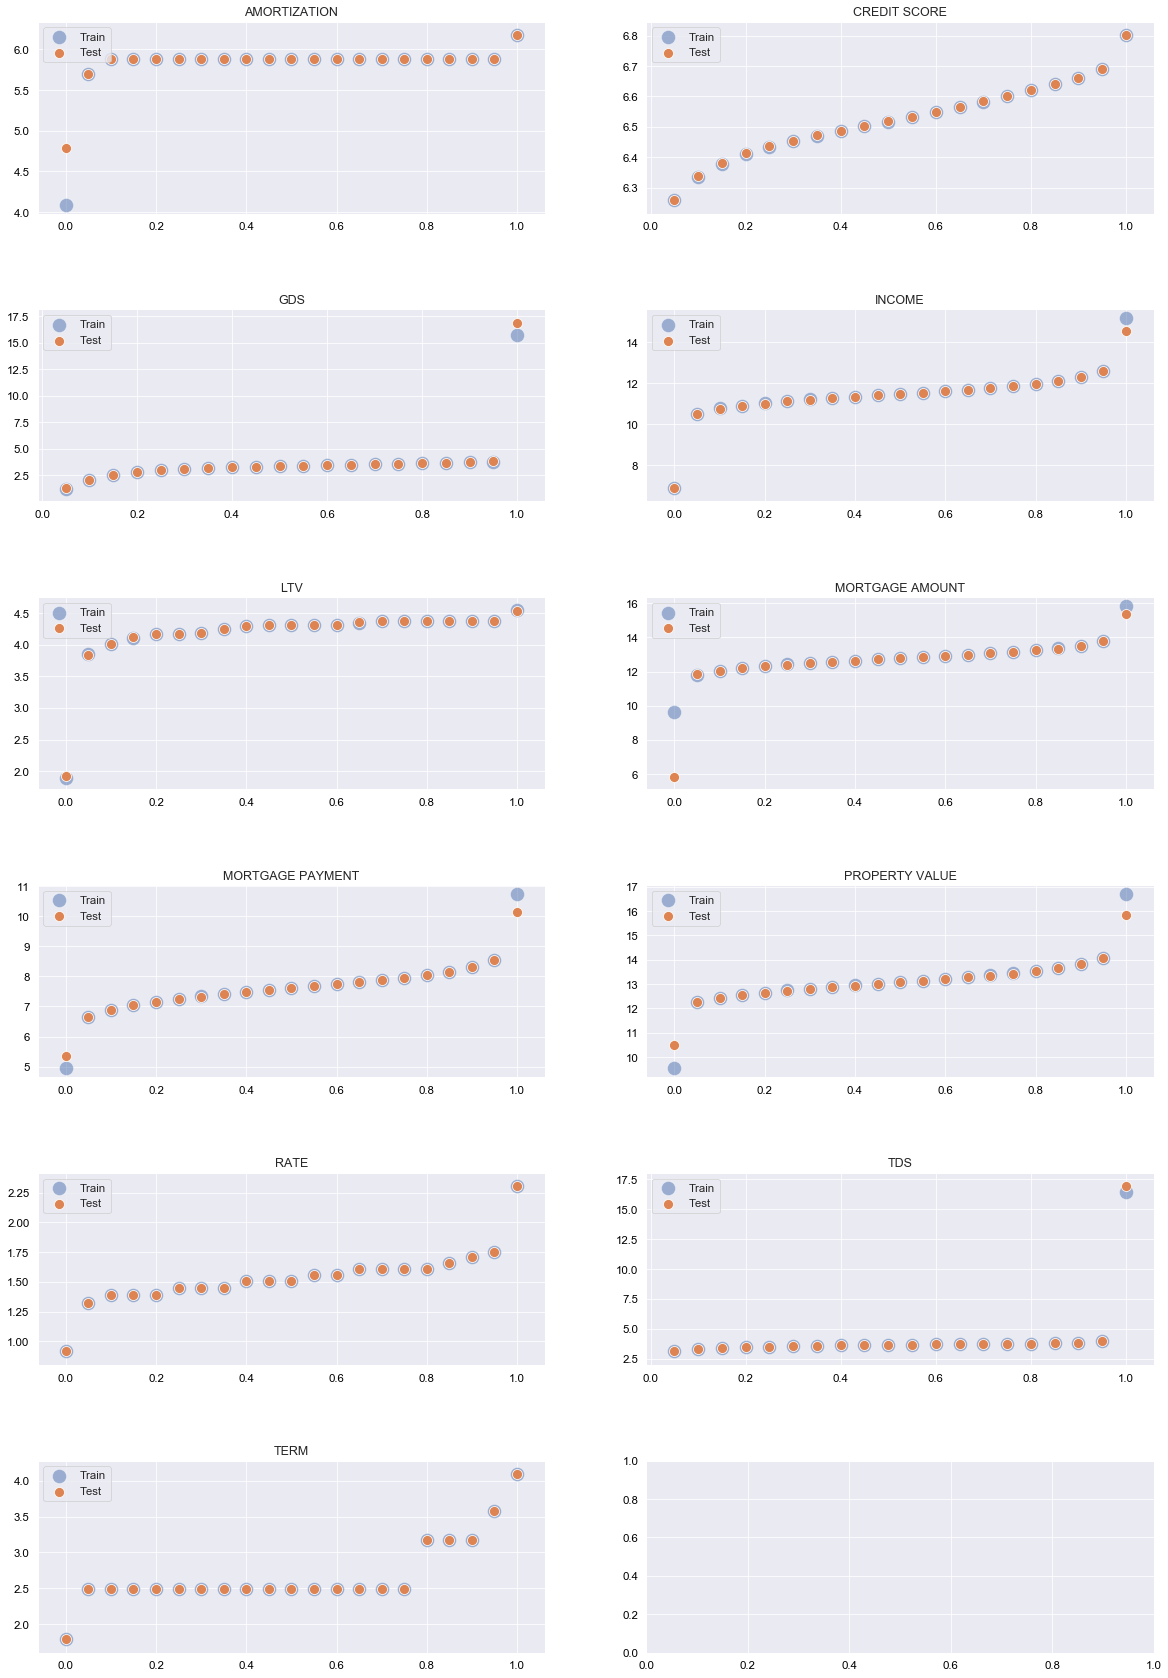

In [29]:
# distribution shift among numerical features between train and test
check_train_test_diff_quantitative( train_df, test_df,  np.setdiff1d(train_df.columns, drop_features+nominal_features+ordinal_features+[target]), log_transform=True )

# Notes:
#  new GDS, TDS values in test set (unseen in training set)
#  GDS: higher the value, higher housing expenses than annual income
#  TDS: higher the value, sum of all expenses are higher than annual income

#  expense factors are probably good indicators of mortage being funded or not

In [24]:
# shift in missing values between train and test set
check_train_test_missing( train_df, test_df,  np.setdiff1d(train_df.columns, drop_features+[target]) )

                   train  test
AGE RANGE         0.000  0.000
AMORTIZATION      0.000  0.000
CREDIT SCORE      0.000  0.000
FSA               0.000  0.000
GDS               0.000  0.000
GENDER            0.000  0.000
INCOME            0.000  0.000
INCOME TYPE       0.000  0.000
LTV               0.000  0.000
MORTGAGE AMOUNT   0.000  0.000
MORTGAGE PAYMENT  0.000  0.000
MORTGAGE PURPOSE  0.000  0.000
NAICS CODE        0.000  0.000
PAYMENT FREQUENCY 0.000  0.000
PROPERTY TYPE     0.000  0.000
PROPERTY VALUE    0.000  0.000
RATE              0.000  0.000
TDS               0.000  0.000
TERM              0.000  0.000


In [25]:
# what are the new categorical levels that pose shift in the datasets?
check_level_diff_nominal(train_df, test_df, nominal_features+ordinal_features)

,feature,no_of_differences,diffs
0,MORTGAGE PURPOSE,0,{}
1,PAYMENT FREQUENCY,0,{}
2,PROPERTY TYPE,0,{}
3,FSA,28,"{C1N, E2S, G1V, G9A, V1H, J2E, H2T, B4P, H1V, T4M, N9A, M3S, J5T, C0A, P0T, B9N, L2K, A0B, T0B, B4R, T1V, N8H, N5L, G8V, M7A, M2Y, H2H, K8B}"
4,GENDER,0,{}
5,NAICS CODE,0,{}
6,AGE RANGE,0,{}
7,INCOME TYPE,0,{}


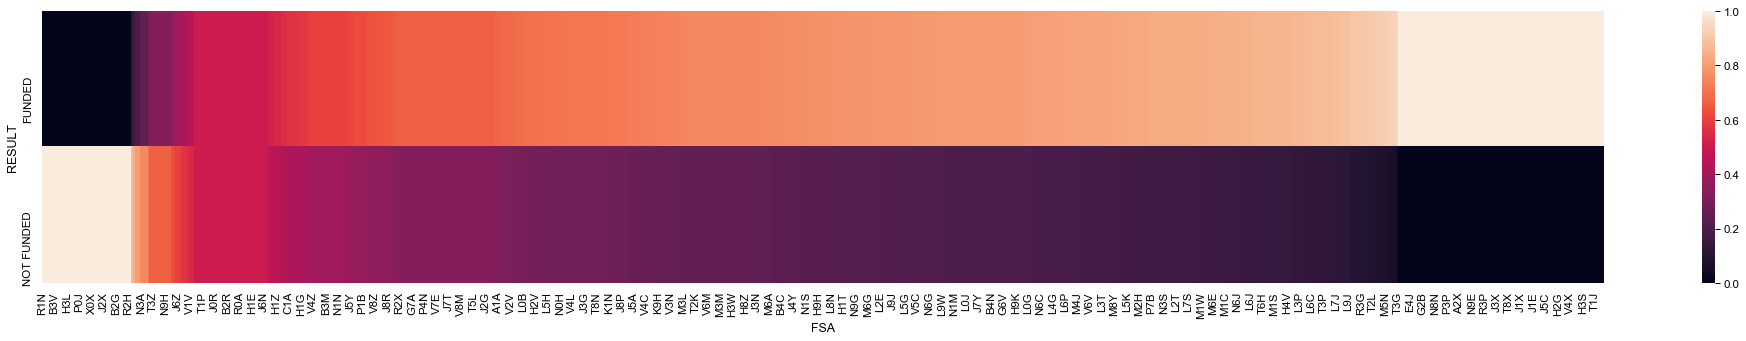

In [139]:
plt.figure(figsize=(35,5))
_ = sns.heatmap(pd.crosstab(train_df["FSA"], train_df["RESULT"], normalize="index").sort_values(["FUNDED"]).T) #, vmin=0, vmax=1)
# Note:
#  Few levels have high uncertainity as show in far left below

In [134]:
# chisq test test of independence between FSA and response
ch_statistic, p_value, _, _ = stats.chi2_contingency(pd.crosstab(train_df["FSA"], train_df["RESULT"]), lambda_="log-likelihood")
print(ch_statistic, p_value)
# FSA is statistically dependent on response (RESULT) mostly because of high cardinality in it

1794.5135436649646 4.4502694775189494e-32


In [125]:
lg_fsa = LogisticRegression()
lg_fsa.fit(pd.get_dummies(train_df["FSA"], drop_first=True), train_df["RESULT"])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

<Figure size 2520x360 with 0 Axes>

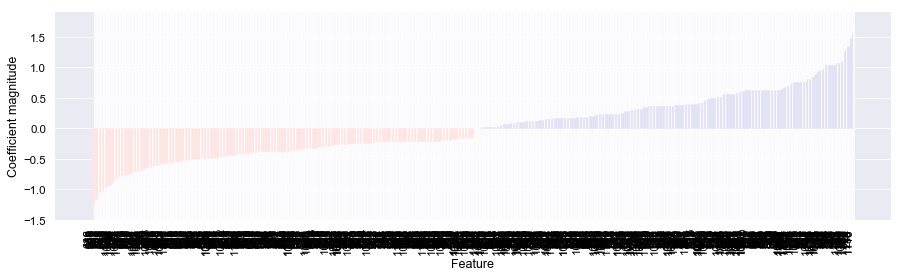

In [128]:
visualize_coefficients( lg_fsa.coef_, np.arange(0,lg_fsa.coef_.shape[1]), n_top_features=500, plot_all=False )
# Hypothesis: 
# ------------
#   FSA is an useful feature as some levels have large positive impact and negative impact respectively on response

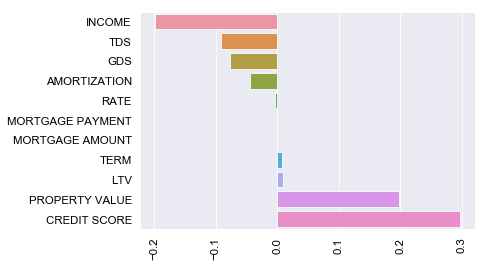

In [37]:
# Model numerical features
from sklearn.preprocessing import scale, robust_scale

lg_fsa = LogisticRegression()
lg_fsa.fit( train_df.drop(nominal_features+ordinal_features+drop_features+[target], axis=1).apply(lambda x: robust_scale(x), axis=0), train_df["RESULT"] )

visualize_coefficients( lg_fsa.coef_, np.setdiff1d(train_df.columns, nominal_features+ordinal_features+drop_features+[target]), plot_all=True)
# Hypothesis:
# ------------
#   Mortage Amount, Mortage payment is irrelevant when all other factors are present

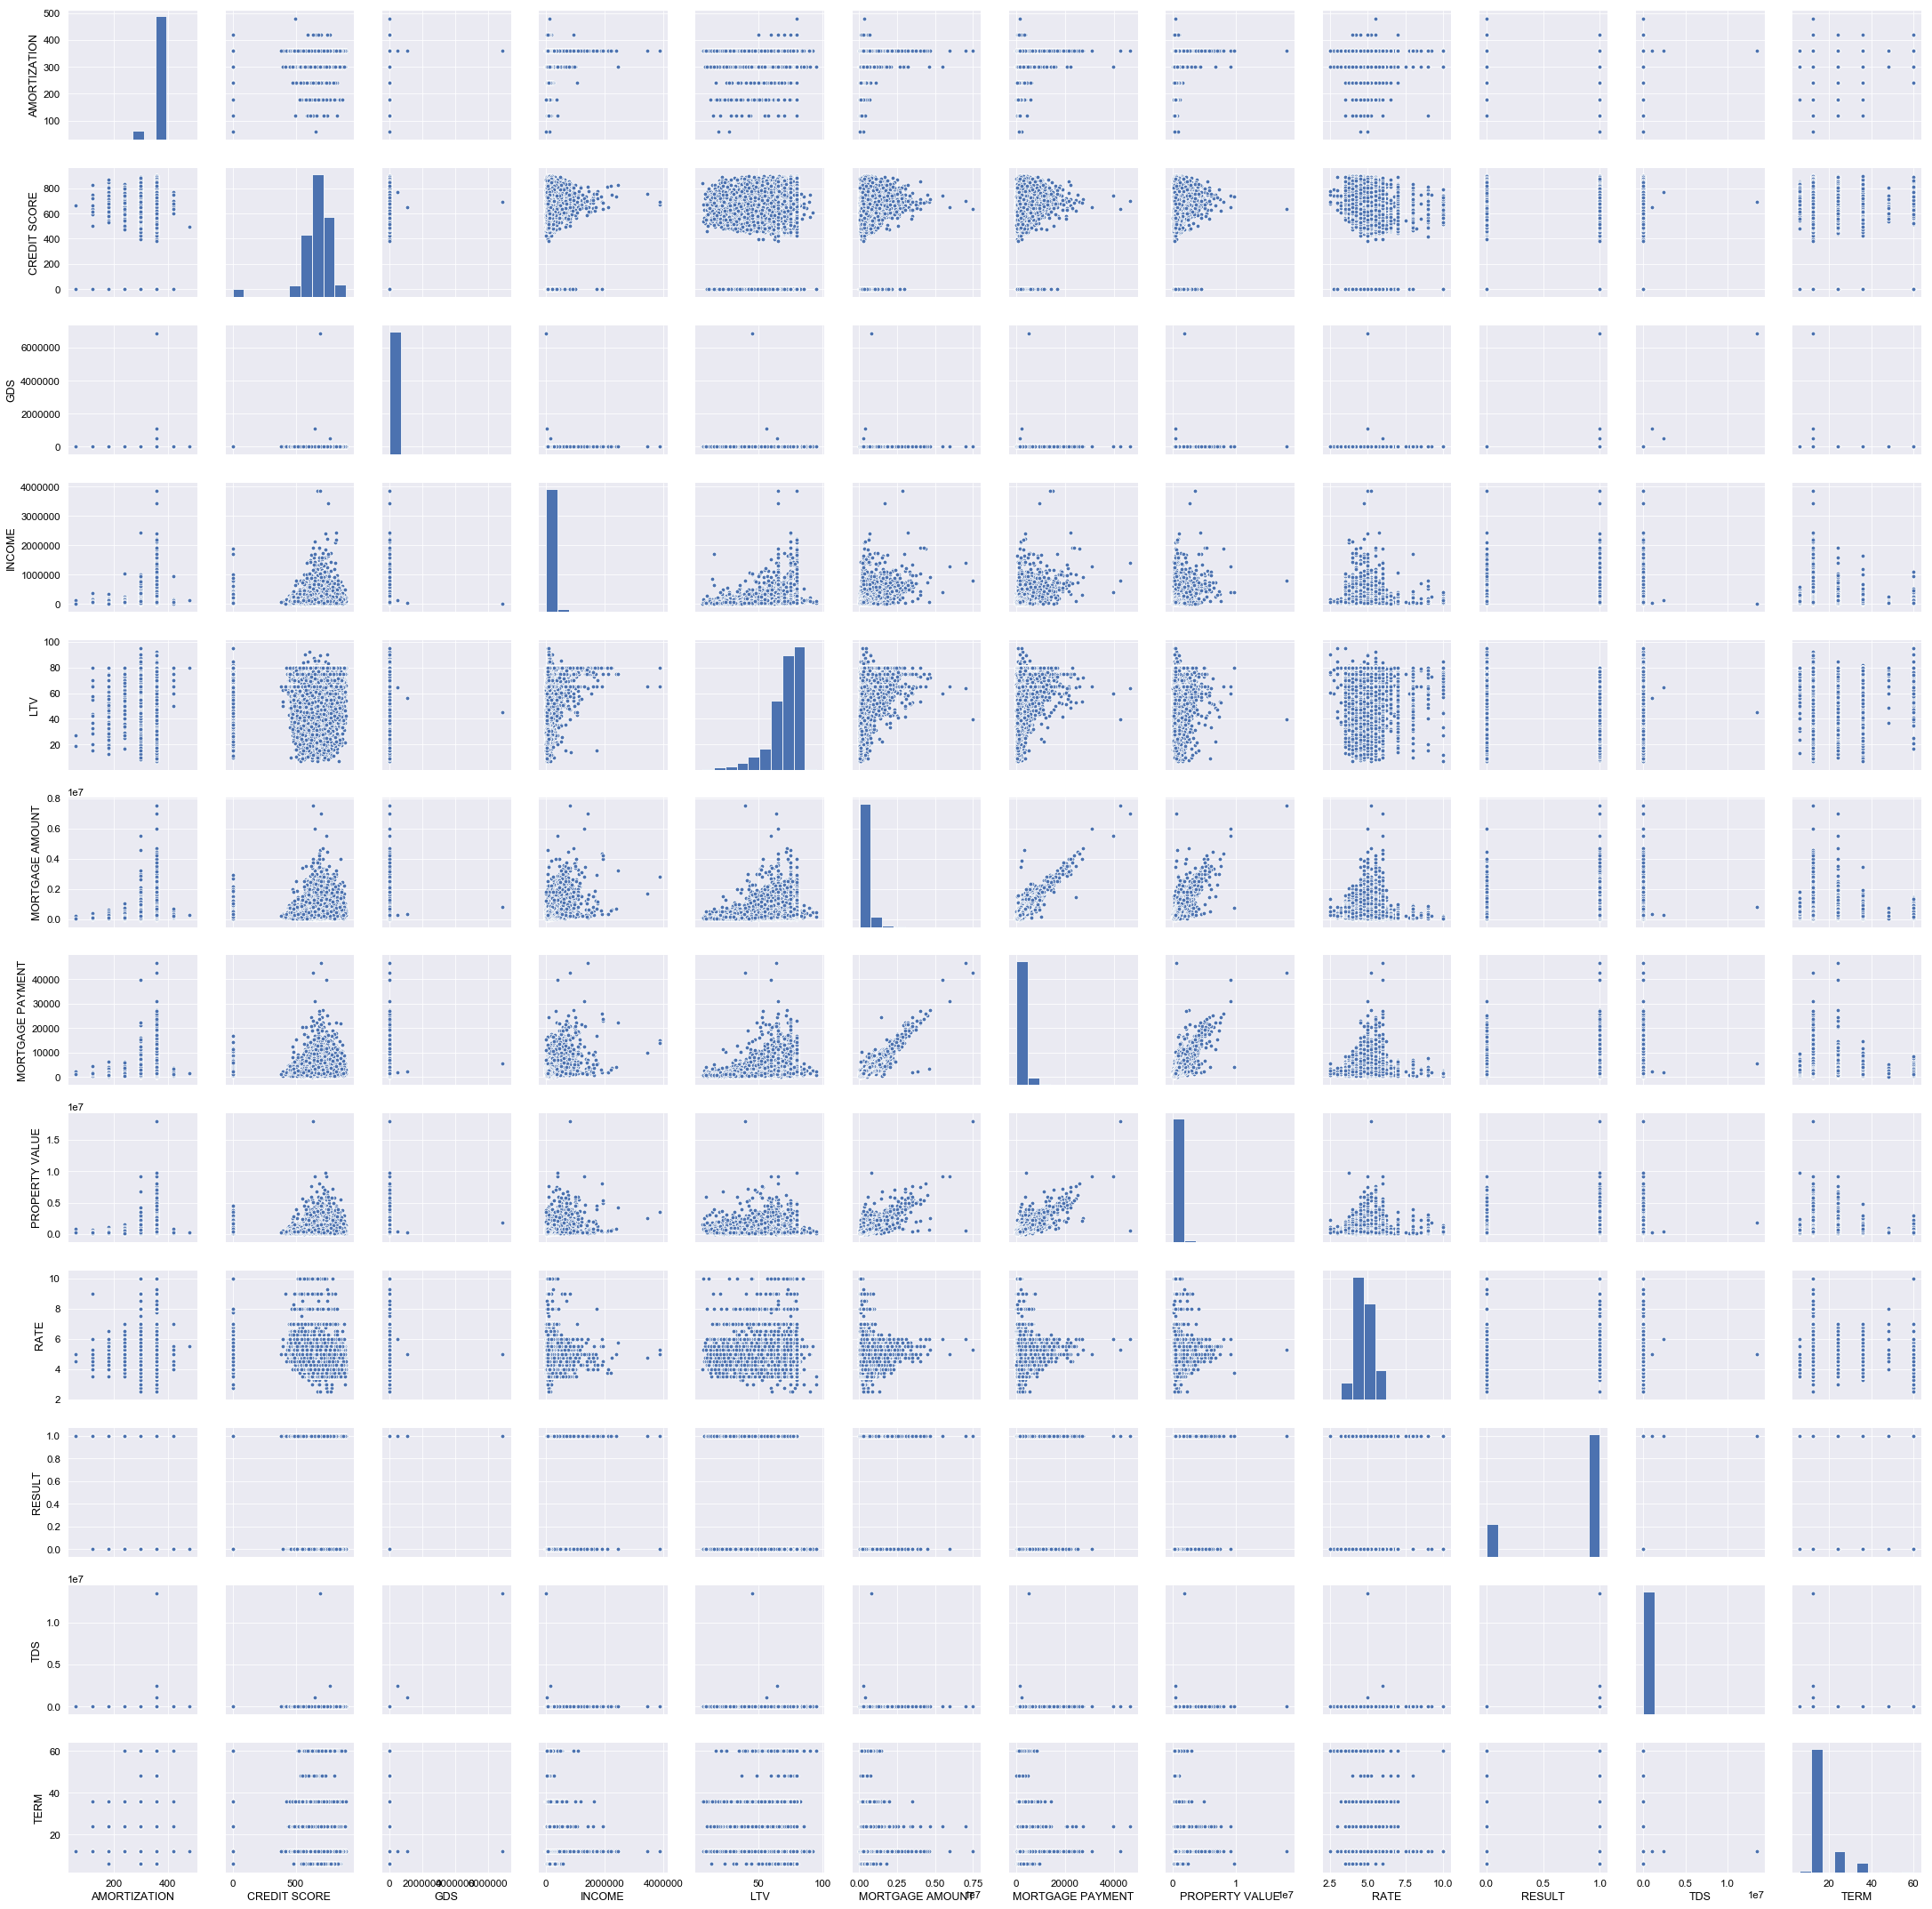

In [119]:
sns.pairplot(train_df[np.setdiff1d(train_df.columns, nominal_features+ordinal_features+drop_features)].apply(lambda x: (x=="FUNDED").astype(np.int8) if x.dtype == "object" else x))

In [32]:
# distribution of numeric features
describe_numeric(train_df, np.setdiff1d(train_df.columns, nominal_features+ordinal_features+drop_features+[target]))

# Note:
# -----
#   Outliers in GDS (very erratic)?
#   TDS, GDS are correlated
#   Outliers in income, mortage amount?
#   Exclude or Treat extreme values? mortage payment, property value
#   Amortization: Near zero variance?

,AMORTIZATION,CREDIT SCORE,GDS,INCOME,LTV,MORTGAGE AMOUNT,MORTGAGE PAYMENT,PROPERTY VALUE,RATE,TDS,TERM
count_non_missing,45642,45642,45642,45642,45642,45642,45642,45642,45642,45642,45642
min,60,0,-37.040,1000,6.667,15000.000,141,14000,2.500,-10.700,6
max,480,899,6872300.000,3860000,95.000,7500000.000,46479,18000000,10.000,13462562.500,60
dtype,int64,int64,float64,int64,float64,float64,int64,int64,float64,float64,int64
%missing,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
mode,360,0,0.000,100000,80.000,300000.000,1349,400000,5.000,0.000,12
mean,355.310,662.663,213.803,125109.307,70.633,425570.447,2392.148,582611.038,4.651,412.567,15.287
median,360.000,677.000,29.210,97000.000,75.000,357500.000,2033.000,477000.000,4.500,38.300,12.000
std,18.012,132.818,32637.664,114997.380,11.566,302046.877,1688.209,438208.209,0.642,64258.595,7.444
nunique,8,469,6027,730,5811,10185,6430,1705,27,5704,6


In [132]:
train_df[np.setdiff1d(train_df.columns, nominal_features+ordinal_features+drop_features+[target])].corr(method='spearman')
# Note:
#   interest rate goes down with higher credit score, ltv, mortage amount, property value

,AMORTIZATION,CREDIT SCORE,GDS,INCOME,LTV,MORTGAGE AMOUNT,MORTGAGE PAYMENT,PROPERTY VALUE,RATE,TDS,TERM
AMORTIZATION,1.000,0.082,0.060,0.093,0.138,0.214,0.164,0.181,-0.144,0.099,-0.024
CREDIT SCORE,0.082,1.000,-0.139,0.153,0.174,0.173,0.125,0.154,-0.361,0.011,-0.026
GDS,0.060,-0.139,1.000,-0.345,-0.072,0.213,0.221,0.235,0.030,0.464,-0.011
INCOME,0.093,0.153,-0.345,1.000,0.249,0.596,0.564,0.526,-0.114,-0.078,-0.059
LTV,0.138,0.174,-0.072,0.249,1.000,0.276,0.234,0.050,-0.256,-0.069,-0.029
MORTGAGE AMOUNT,0.214,0.173,0.213,0.596,0.276,1.000,0.930,0.904,-0.230,0.164,-0.076
MORTGAGE PAYMENT,0.164,0.125,0.221,0.564,0.234,0.930,1.000,0.863,-0.116,0.174,-0.085
PROPERTY VALUE,0.181,0.154,0.235,0.526,0.050,0.904,0.863,1.000,-0.200,0.181,-0.082
RATE,-0.144,-0.361,0.030,-0.114,-0.256,-0.230,-0.116,-0.200,1.000,0.088,0.025
TDS,0.099,0.011,0.464,-0.078,-0.069,0.164,0.174,0.181,0.088,1.000,-0.035


In [145]:
# peek into extreme values
train_df.query("INCOME > 600000")
# inspect: CAX_Train_46, CAX_Train_186

,Unique_ID,MORTGAGE NUMBER,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,MORTGAGE PURPOSE,PAYMENT FREQUENCY,PROPERTY TYPE,TERM,FSA,AGE RANGE,GENDER,INCOME,INCOME TYPE,NAICS CODE,CREDIT SCORE,RESULT
45,CAX_Train_46,46,310000,1564,0.830,80.000,38.100,360,247833.680,5.500,Purchase,Monthly,High Rise,12,L6A,40-44,Unknown,1200000,8,62,645,FUNDED
185,CAX_Train_186,186,342000,1503,0.680,75.000,19.660,360,256800.000,4.500,Purchase,Monthly,High Rise,12,M5A,35-39,Male,1500000,8,53,617,NOT FUNDED
187,CAX_Train_188,188,348000,1428,2.620,65.000,18.900,360,278263.060,4.500,Purchase,Monthly,Townhouse Freehold,12,N3W,45-49,Female,700000,8,53,732,FUNDED
300,CAX_Train_301,301,3525000,15033,7.960,80.000,23.900,360,2820000.000,5.000,Purchase,Monthly,Single Detached,12,M5P,70 and over,Male,3860000,8,23,671,NOT FUNDED
397,CAX_Train_398,398,1435000,6658,40.850,80.000,40.850,360,1200000.000,4.750,Refinance,Monthly,Single Detached,12,L4B,35-39,Male,928000,8,23,737,FUNDED
434,CAX_Train_435,435,1000000,3283,17.920,70.000,41.780,360,700000.000,4.000,Refinance,Monthly,Single Detached,12,M9M,60-64,Male,900000,8,56,670,FUNDED
558,CAX_Train_559,559,175000,980,1.990,75.000,33.520,360,113750.000,6.000,Purchase,Monthly,Single Detached,12,L4N,40-44,Unknown,1432000,8,11,644,FUNDED
593,CAX_Train_594,594,590000,3242,6.120,80.000,42.390,300,472000.000,5.000,Purchase,Monthly,High Rise,12,M6P,65-69,Unknown,700000,8,54,723,NOT FUNDED
630,CAX_Train_631,631,5050000,19512,70.570,65.000,70.570,360,3750000.000,5.500,Refinance,Monthly,Single Detached,12,V6H,45-49,Male,991000,8,53,683,FUNDED
850,CAX_Train_851,851,1840000,7535,11.530,80.000,26.390,360,1472000.000,4.000,Purchase,Monthly,Single Detached,12,M5M,40-44,Male,995000,8,23,826,NOT FUNDED


In [152]:
train_df.query("FSA == 'M5A' and GENDER == 'Male'")[train_df["AGE RANGE"] == '35-39']["RESULT"].value_counts()
#train_df.query("FSA == 'M5A'")[train_df["AGE RANGE"] == '35-39']["RESULT"].value_counts()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


FUNDED        7
NOT FUNDED    6
Name: RESULT, dtype: int64

In [36]:
# peek: AMORTIZATION
pd.crosstab(index=train_df["AMORTIZATION"], values=train_df[object_id], columns=train_df["RESULT"], aggfunc=lambda x: len(x), normalize="index")

# lower values -> funded, higher values -> not funded, middle -> mixed bag (requires interaction)

RESULT,FUNDED,NOT FUNDED
AMORTIZATION,,
60,1.000,0.000
120,0.933,0.067
180,0.772,0.228
240,0.880,0.120
300,0.754,0.246
360,0.792,0.208
420,0.364,0.636
480,0.000,1.000


0.0018001718562938084


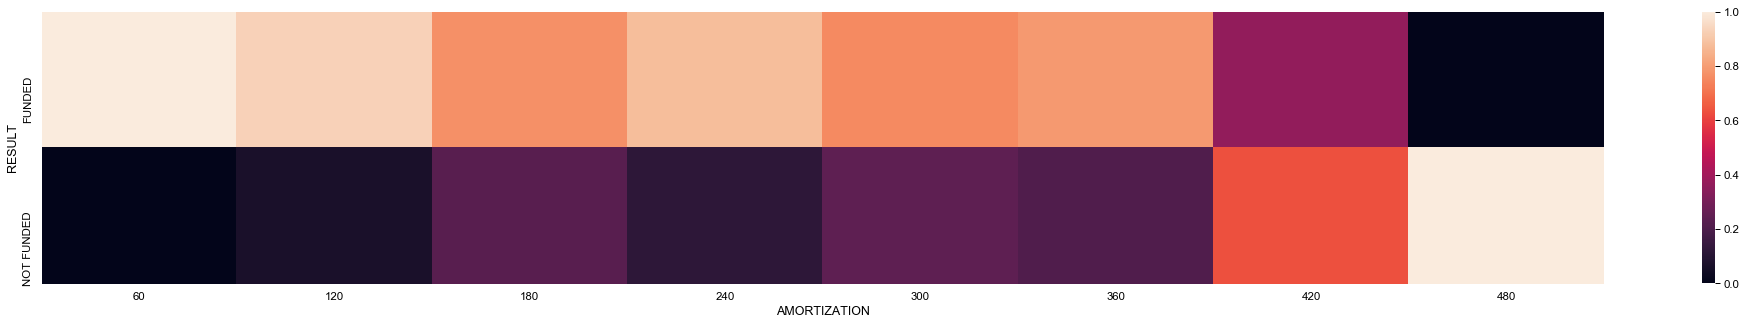

In [135]:
print( info_gain_ratio(train_df["AMORTIZATION"], train_df["RESULT"]) )
plt.figure(figsize=(35,5))
sns.heatmap(pd.crosstab(train_df["AMORTIZATION"], train_df["RESULT"], normalize="index").T, annot=False)

0.8938592354980059
0.13603409784758008


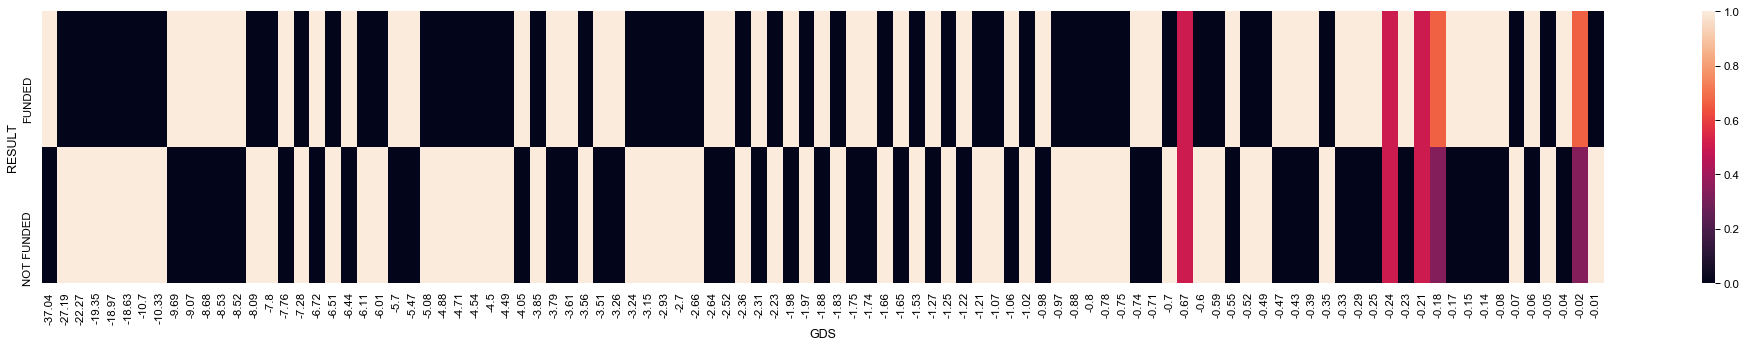

In [134]:
# peek: GDS
plt.figure(figsize=(35,5))
query = train_df[(train_df["GDS"] < 0)].loc[:, ["GDS", "RESULT"]]
sns.heatmap(pd.crosstab(query["GDS"], query["RESULT"], normalize="index").T, annot=False) #sort_values(["FUNDED"]).T

print( mutual_information(query["GDS"], query["RESULT"]) )
print( info_gain_ratio(query["GDS"], query["RESULT"]) )
# extreme values aren't outliers because they carry information in this complicated region

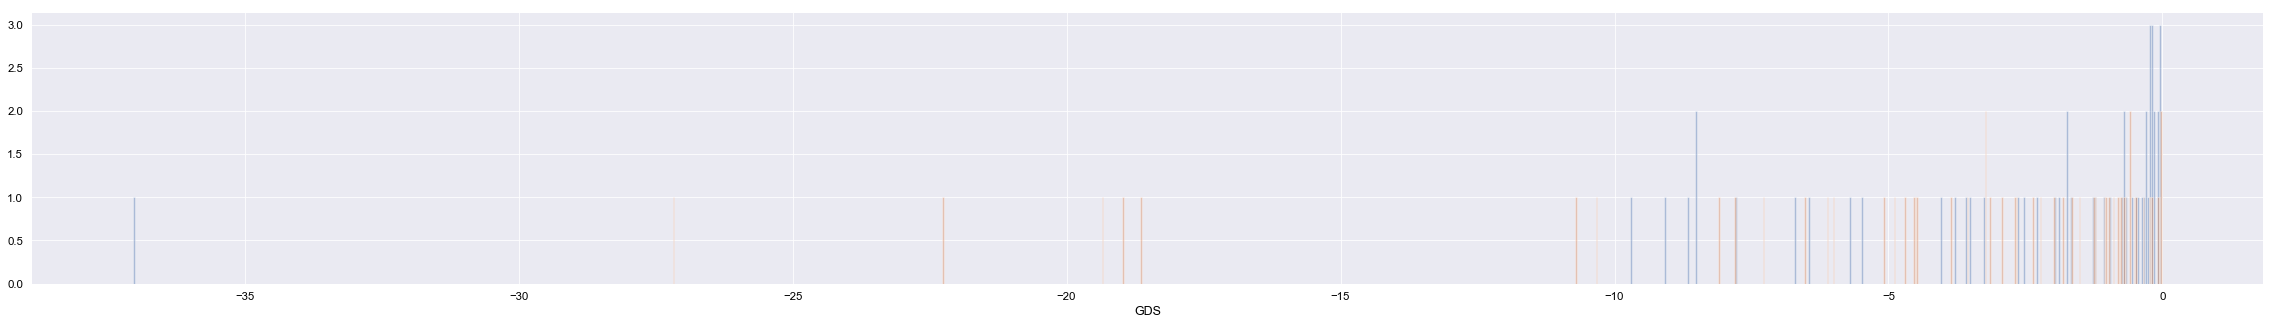

In [102]:
plt.figure(figsize=(40,5))
sns.distplot(query[query["RESULT"] == "FUNDED"]["GDS"], bins=1000, kde=False, vertical=False)
sns.distplot(query[query["RESULT"] == "NOT FUNDED"]["GDS"], bins=1000, kde=False, vertical=False)

0.3840153312388006
0.057369625086039384


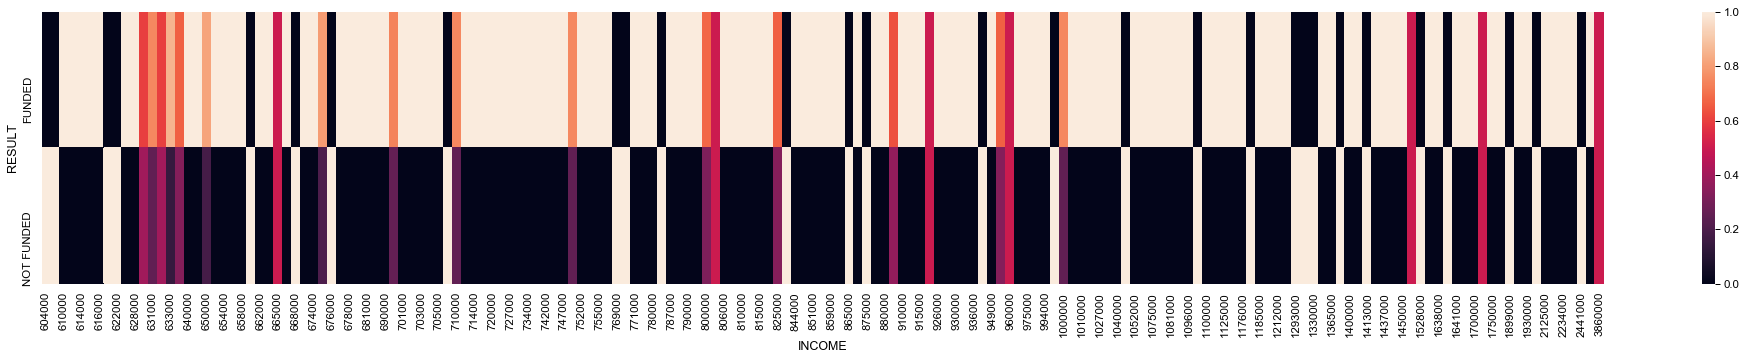

In [133]:
# peek: INCOME
plt.figure(figsize=(35,5))
query = train_df[(train_df["INCOME"] > 600000)].loc[:, ["INCOME", "RESULT"]]
sns.heatmap(pd.crosstab(query["INCOME"], query["RESULT"], normalize="index").T, annot=False) # .sort_values(["FUNDED"]).T

print( mutual_information(query["INCOME"], query["RESULT"]))
print( info_gain_ratio(query["INCOME"], query["RESULT"]) )

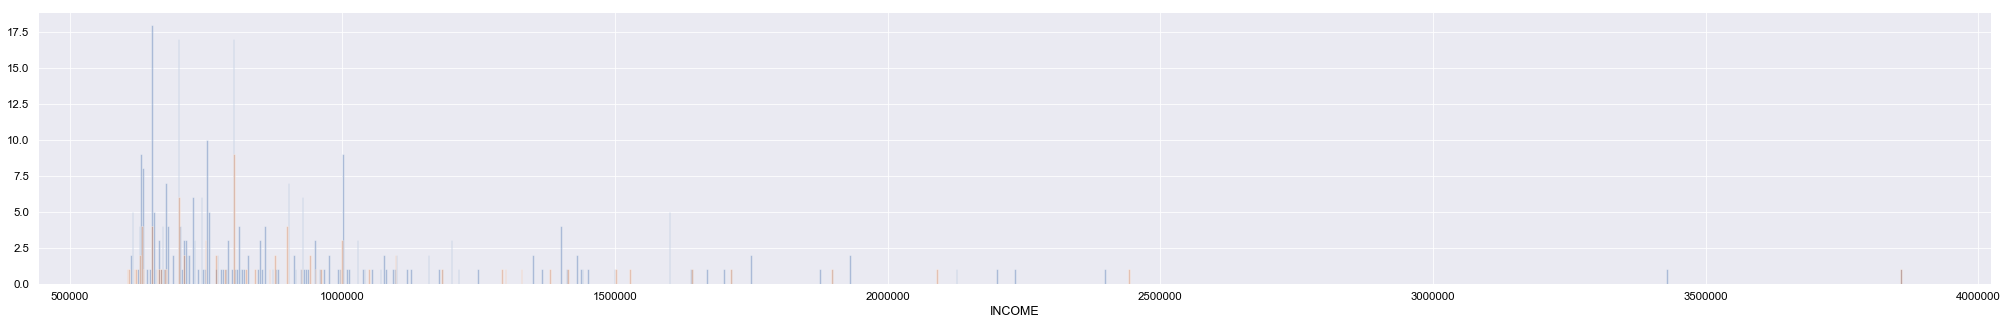

In [98]:
plt.figure(figsize=(35,5))
sns.distplot(query[query["RESULT"] == "FUNDED"]["INCOME"], bins=1000, kde=False, vertical=False)
sns.distplot(query[query["RESULT"] == "NOT FUNDED"]["INCOME"], bins=1000, kde=False, vertical=False)

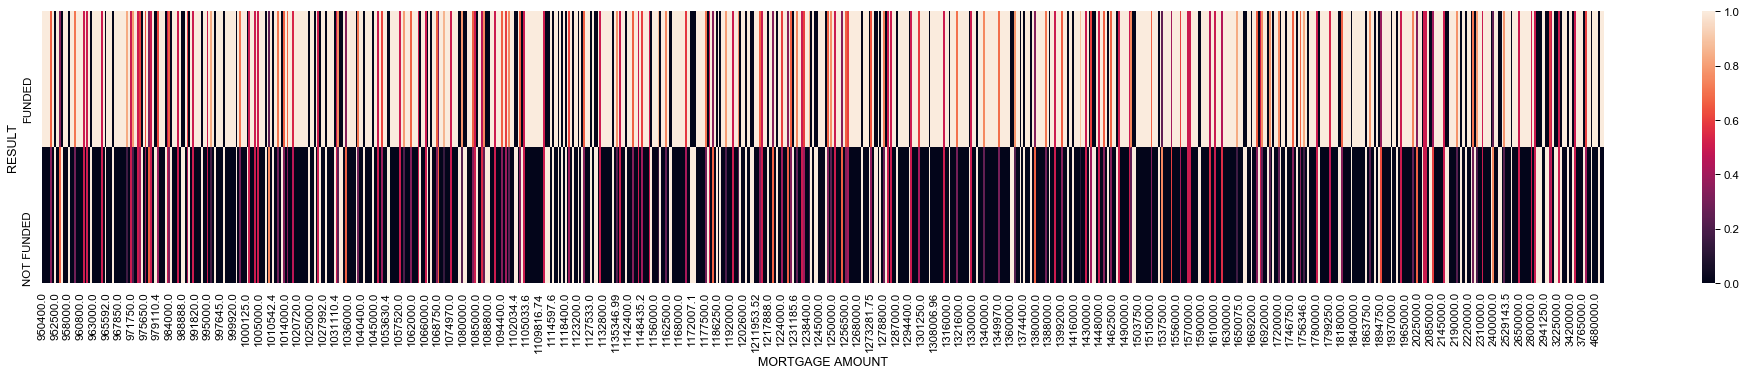

In [104]:
# peek: MORTGAGE AMOUNT
plt.figure(figsize=(35,5))
sns.heatmap(pd.crosstab(train_df[(train_df["MORTGAGE AMOUNT"] > 950000)]["MORTGAGE AMOUNT"], train_df["RESULT"], normalize="index").T)#sort_values(["FUNDED"]).T)
# complex surface, randomness

In [132]:
query = train_df[(train_df["MORTGAGE AMOUNT"] > 950000)][["MORTGAGE AMOUNT", "RESULT"]]
print( mutual_information(query["MORTGAGE AMOUNT"], query["RESULT"]) )
print( info_gain_ratio(query["MORTGAGE AMOUNT"], query["RESULT"]) )

0.3181878787763921
0.037825983340432724


0.10838706482029359


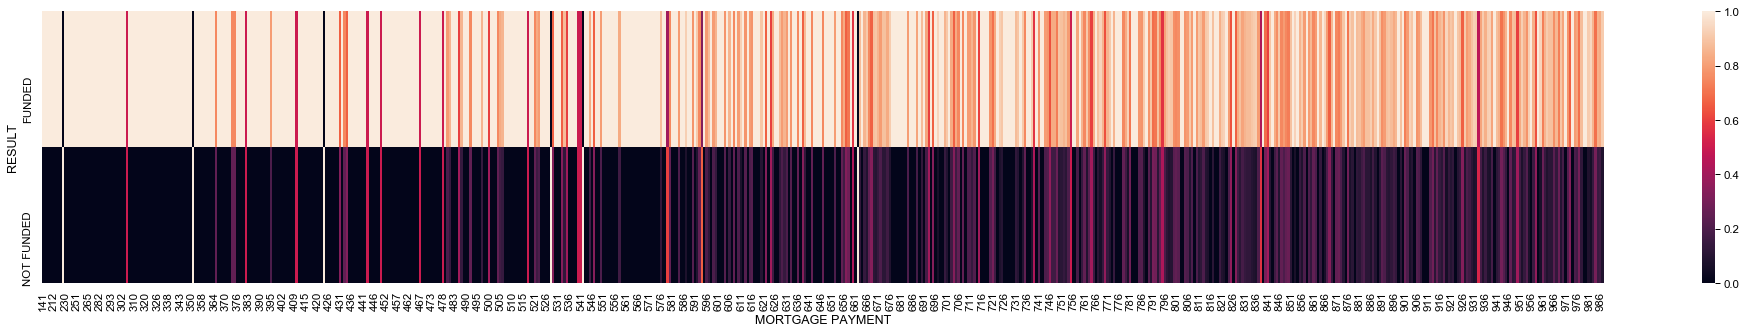

In [105]:
# peek: MORTGAGE PAYMENT
plt.figure(figsize=(35,5))
sns.heatmap(pd.crosstab(train_df[(train_df["MORTGAGE PAYMENT"] < 988)]["MORTGAGE PAYMENT"], train_df["RESULT"], normalize="index").T) #.sort_values(["FUNDED"]).T
# noisy region, randomness

print( mutual_information(train_df[(train_df["MORTGAGE PAYMENT"] < 988)]["MORTGAGE PAYMENT"], train_df[(train_df["MORTGAGE PAYMENT"] < 988)]["RESULT"]) )

In [110]:
for feat in np.setdiff1d(train_df.columns, drop_features+[target]):
    print(feat, ":", mutual_information(train_df[feat], train_df[target]) )

# Hypothesis:
# -------------
# Simpson's Paradox:
#   Information captured in certain regions of GDS, INCOME, MORTAGE AMOUNT tends to lower when combined

AGE RANGE : 0.0005137808404573896
AMORTIZATION : 0.0007314851610298323
CREDIT SCORE : 0.011907598959300714
FSA : 0.02836133156142573
GDS : 0.11465061833499668
GENDER : 0.00039206517680501207
INCOME : 0.014137575041260675
INCOME TYPE : 0.0012208715991786079
LTV : 0.2066542693153437
MORTGAGE AMOUNT : 0.16824327010794882
MORTGAGE PAYMENT : 0.12769749335791047
MORTGAGE PURPOSE : 0.0074342023654654366
NAICS CODE : 0.003104642243896727
PAYMENT FREQUENCY : 0.02216540326361205
PROPERTY TYPE : 0.0018935568541866843
PROPERTY VALUE : 0.04143089264292321
RATE : 0.008371423290900903
TDS : 0.11669421926460544
TERM : 0.002784647805777807


### Things to try

<br/>

1. With and without Group-wise validation n FSA (Assuming samples aren't IID)
2. Treat GSA, INCOME, MORTAGE AMOUNT as categorical
3. Treat extremes of GSA, INCOME, MORTAGE AMOUNT
4. Ensemble of validation strategies
5. Play with large bin sizes in GSA, INCOME, MORTAGE AMOUNT features to model complexity
6. Keep vs. Drop correlated features (Matrix factorization on numeric features)
7. Feat. engineering with FSA
